# Maquina de soporte vectorial 

Modelo de machine learning no paramétrico,matemáticamente compleja y computacionalmente costosa.

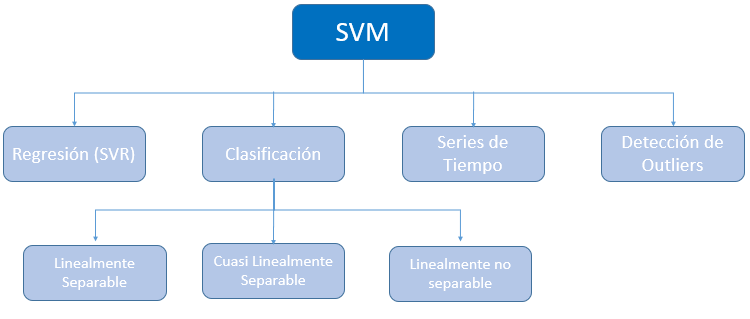

Abordaremos la máquina de soporte vectorial para el caso de clasificación binaria. En la imagen podemos observar los casos que se tienen:
1. Linealmente separable: Mediante un hiperplano que corta los subconjuntos de datos se busca encontrar el mayor margen entre los vectores de soporte.
2. Cuasi lineamente separable: Se introduce el concepto de holgura y regularización, que permitirá cuantificar el número de ejemplos no-separables que se está dispuesto a admitir y que tan suave será la admisión de los errores.
3. Linealmento no separable: Aplicando un Kernel a los datos se busca cambiar la dimensión para encontrar algún hiperplano que separe las categorías.

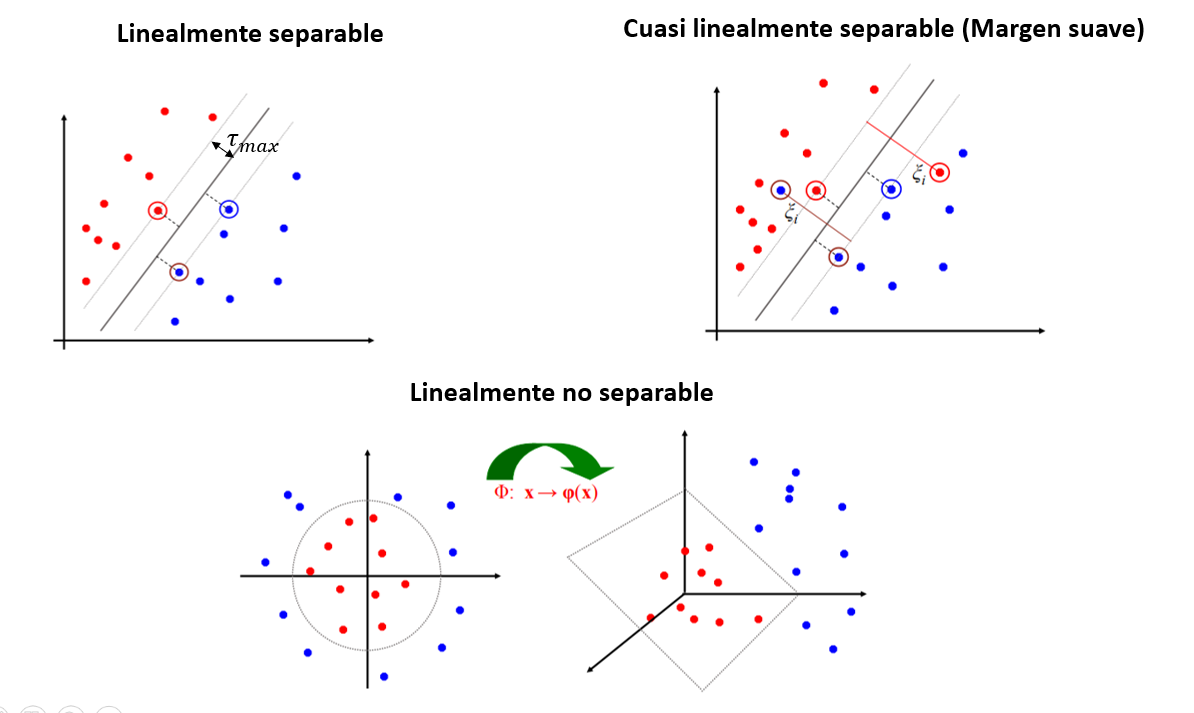

**En el siguiente video se explica de manera detallada el concepto y desarrollo matemático del svm para clasificación.**

https://www.coursera.org/lecture/clasificacion-imagenes/support-vector-machines-svm-conceptos-basicos-52lRD

**Preguntas**

¿Qué son los vectores de soporte?

¿Para que sirve el parámetro de holgura?

¿Qué es el parámetro de regularización?

¿Para que y por qué necesito usar el kernel trick?

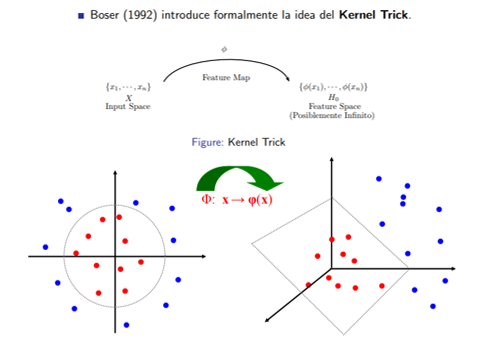

https://scikit-learn.org/stable/modules/svm.html#svm-mathematical-formulation

## Implementación 

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#

### Carga de Librerías 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import warnings
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import timeit

**Ruta**

In [2]:
ruta_input="C:/Users/Omar/Desktop/Omar/Temas data science/Bases/Credit car"

In [3]:
base_input=pd.read_excel(os.path.join(ruta_input,"default of credit card clients.xls"),header=1)

In [4]:
base_input.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
base_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

**Renombramos dataset**

In [6]:
base_input=base_input.iloc[:,1:]

In [7]:
colum_base=["credito_otorgado($)","genero","educacion","estado_civil","edad","marca_pago_mes_6","marca_pago_mes_5",
            "marca_pago_mes_4","marca_pago_mes_3","marca_pago_mes_2","marca_pago_mes_1","estado_cuenta_mes_6($)",
            "estado_cuenta_mes_5($)","estado_cuenta_mes_4($)","estado_cuenta_mes_3($)","estado_cuenta_mes_2($)",
            "estado_cuenta_mes_1($)","monto_pago_anterior_6($)","monto_pago_anterior_5($)","monto_pago_anterior_4($)",
            "monto_pago_anterior_3($)","monto_pago_anterior_2($)","monto_pago_anterior_1($)","incumplimiento_sgte_mes"]

In [8]:
base_input.columns=colum_base

Como es el mismo ejemplo del modelo construido con regresión logística, vamos directo a la implementación del modelo.

**featuring engineering**

In [9]:
base_input.loc[base_input['genero']==1,'genero']='masculino'
base_input.loc[base_input['genero']==2,'genero']='femenino'
base_input.loc[(base_input['educacion']>3) | (base_input['educacion']==0),'educacion']='otros'
base_input.loc[base_input['educacion']==1,'educacion']='posgrado'
base_input.loc[base_input['educacion']==2,'educacion']='universidad'
base_input.loc[base_input['educacion']==3,'educacion']='bachillerato'
base_input.loc[(base_input['estado_civil']==3) | (base_input['estado_civil']==0),'estado_civil']='otros'
base_input.loc[base_input['estado_civil']==1,'estado_civil']='casado'
base_input.loc[base_input['estado_civil']==2,'estado_civil']='soltero'

In [10]:
base_dummies=pd.get_dummies(base_input[['genero','educacion','estado_civil']])
base_input=pd.concat([base_input,base_dummies],axis=1)
base_input.drop(columns=["genero","educacion","estado_civil","edad"],inplace=True)

estandarización

In [11]:
base=base_input.copy()
X=base_input.drop(columns=["incumplimiento_sgte_mes"])

In [12]:
Y=base_input[["incumplimiento_sgte_mes"]]
Y['incumplimiento_sgte_mes']=Y['incumplimiento_sgte_mes'].apply(int)

C:\Users\Omar\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
scaler = MinMaxScaler()
X_scaler = scaler.fit_transform(X)
X_scaler = pd.DataFrame(X_scaler)
X_scaler.columns = X.columns

**Correlación de variables**

In [14]:
correlacion=np.round(X_scaler.corr(),2)
correlacion=np.round(X_scaler.corr(),2)
correlacion = correlacion.unstack().sort_values() 
correlacion=pd.DataFrame(correlacion).reset_index()

In [15]:
correlacion.columns=['var1','var2','cor']
var_nocor=correlacion.loc[(correlacion['cor']>-0.1) & (correlacion['cor']<0.1),'var1'].unique()

In [16]:
print(var_nocor)

['credito_otorgado($)' 'estado_civil_soltero' 'educacion_otros'
 'educacion_posgrado' 'monto_pago_anterior_6($)' 'marca_pago_mes_5'
 'marca_pago_mes_6' 'marca_pago_mes_3' 'monto_pago_anterior_4($)'
 'monto_pago_anterior_5($)' 'genero_femenino' 'marca_pago_mes_4'
 'educacion_bachillerato' 'monto_pago_anterior_2($)'
 'monto_pago_anterior_3($)' 'estado_civil_otros' 'marca_pago_mes_2'
 'educacion_universidad' 'monto_pago_anterior_1($)' 'marca_pago_mes_1'
 'estado_cuenta_mes_5($)' 'estado_cuenta_mes_3($)'
 'estado_cuenta_mes_2($)' 'estado_cuenta_mes_1($)'
 'estado_cuenta_mes_6($)' 'estado_civil_casado' 'genero_masculino'
 'estado_cuenta_mes_4($)']


In [17]:
X_scaler2=X_scaler[var_nocor]
X_scaler2.head()

,credito_otorgado($),estado_civil_soltero,educacion_otros,educacion_posgrado,monto_pago_anterior_6($),marca_pago_mes_5,marca_pago_mes_6,marca_pago_mes_3,monto_pago_anterior_4($),monto_pago_anterior_5($),...,monto_pago_anterior_1($),marca_pago_mes_1,estado_cuenta_mes_5($),estado_cuenta_mes_3($),estado_cuenta_mes_2($),estado_cuenta_mes_1($),estado_cuenta_mes_6($),estado_civil_casado,genero_masculino,estado_cuenta_mes_4($)
0,0.010101,0.0,0.0,0.0,0.000000,0.4,0.4,0.1,0.000000,0.000409,...,0.000000,0.0,0.069164,0.160138,0.080648,0.260979,0.149982,1.0,0.0,0.086723
1,0.111111,1.0,0.0,0.0,0.000000,0.4,0.1,0.2,0.001116,0.000594,...,0.003783,0.4,0.067858,0.163220,0.084074,0.263485,0.148892,0.0,0.0,0.087817
2,0.080808,1.0,0.0,0.0,0.001738,0.2,0.2,0.2,0.001116,0.000891,...,0.009458,0.2,0.079532,0.173637,0.095470,0.272928,0.172392,0.0,0.0,0.093789
3,0.040404,0.0,0.0,0.0,0.002290,0.2,0.2,0.2,0.001339,0.001199,...,0.001892,0.2,0.111995,0.186809,0.109363,0.283685,0.188100,1.0,0.0,0.113407
4,0.040404,0.0,0.0,0.0,0.002290,0.2,0.1,0.2,0.011160,0.021779,...,0.001284,0.2,0.071601,0.179863,0.099633,0.275681,0.154144,1.0,1.0,0.106020


### Train y test para el modelo 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_scaler2, Y, test_size=0.3, random_state=889)
columns = X_train.columns

**Implementación del modelo**

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

### Primero, probaremos con el kernel lineal

In [19]:
svm_modelo_1 = svm.SVC(kernel='linear', C=1, class_weight='balanced',decision_function_shape='ovo',probability=True,random_state =101)
svm_modelo_1.fit(X_train, y_train.values.ravel())

SVC(C=1, class_weight='balanced', decision_function_shape='ovo',
    kernel='linear', probability=True, random_state=101)

In [20]:
prediccion_1 = svm_modelo_1.predict(X_test)

**Evaluación del modelo**

In [21]:
from sklearn.metrics import confusion_matrix
labels = np.array([0, 1])
confusion_matrix_1 = confusion_matrix(y_test, prediccion_1, labels = labels)
pd.DataFrame(confusion_matrix_1, index = labels, columns = labels)

,0,1
0,5903,1044
1,977,1076


In [22]:
print(classification_report(y_test, prediccion_1))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      6947
           1       0.51      0.52      0.52      2053

    accuracy                           0.78      9000
   macro avg       0.68      0.69      0.68      9000
weighted avg       0.78      0.78      0.78      9000



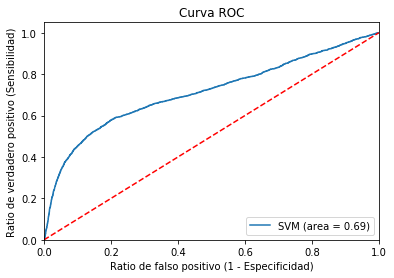

In [23]:
curva_roc = roc_auc_score(y_test, svm_modelo_1.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, svm_modelo_1.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % curva_roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio de falso positivo (1 - Especificidad)')
plt.ylabel('Ratio de verdadero positivo (Sensibilidad)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.savefig('Curva_roc')
plt.show()

In [24]:
print("Gini: ",2*curva_roc-1)

Gini:  0.3738303602861579


### Veamos con un kernel radial

In [25]:
svm_modelo_2 = svm.SVC(kernel='rbf', C=1, class_weight='balanced',decision_function_shape='ovo',probability=False,random_state =111)
svm_modelo_2.fit(X_train, y_train.values.ravel())
prediccion_2 = svm_modelo_2.predict(X_test)

**Evaluación del modelo**

In [26]:
from sklearn.metrics import confusion_matrix
labels = np.array([0, 1])
confusion_matrix_2 = confusion_matrix(y_test, prediccion_2, labels = labels)
pd.DataFrame(confusion_matrix_2, index = labels, columns = labels)

,0,1
0,5854,1093
1,906,1147


In [27]:
print(classification_report(y_test, prediccion_2))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      6947
           1       0.51      0.56      0.53      2053

    accuracy                           0.78      9000
   macro avg       0.69      0.70      0.69      9000
weighted avg       0.79      0.78      0.78      9000



In [28]:
curva_roc_2 = roc_auc_score(y_test,prediccion_2)
print("AUC: ",curva_roc_2)
print("Gini: ",2*curva_roc_2-1)

AUC:  0.7006802461136581
Gini:  0.4013604922273162


### Usemos GridsearchCV 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Nos permite definir los valores que tomaran los hiperparámetros del modelo, con lo cual se ejecutarán los distintos escenarios obteniendo el **best modelo**

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

Para el cross validation:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html

**Implementación**

Definimos el modelo

In [29]:
svm_modelo_3 = svm.SVC(class_weight='balanced',decision_function_shape='ovo')

Se probó con los kernel: lineal, sigmoide y rbf; además, de varios valores de C, gamma. Pero por tiempo de ejecución, solo se muestra el kernel polinomial y rbf.

In [30]:
param_grid ={'kernel' : ['poly','rbf'],
              'C' : list(range(1,3)),
              'gamma' : ['scale',0.5],
             'degree' : [3,4]}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=901)

In [31]:
grid_svm = GridSearchCV(estimator=svm_modelo_3, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
#roc_auc_ovo

In [32]:
start_time = timeit.default_timer()
grid_svm_result = grid_svm.fit(X_train, y_train.values.ravel())
elapsed = timeit.default_timer() - start_time

C:\Users\Omar\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [33]:
print("El tiempo (min) en calcular el gridsearchCV fue de: ",elapsed/60)

El tiempo (min) en calcular el gridsearchCV fue de:  43.11791228166667


**Veamos los resultados**

In [34]:
means = grid_svm_result.cv_results_['mean_test_score']
stds = grid_svm_result.cv_results_['std_test_score']
params = grid_svm_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("Promedio del score es %f, con std de: (%f), y parametros: %r" % (mean, stdev, param))

Promedio del score es 0.514833, con std de: (0.012016), y parametros: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Promedio del score es 0.517535, con std de: (0.013049), y parametros: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Promedio del score es 0.519212, con std de: (0.011021), y parametros: {'C': 1, 'degree': 3, 'gamma': 0.5, 'kernel': 'poly'}
Promedio del score es 0.516933, con std de: (0.012925), y parametros: {'C': 1, 'degree': 3, 'gamma': 0.5, 'kernel': 'rbf'}
Promedio del score es 0.518578, con std de: (0.011283), y parametros: {'C': 1, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}
Promedio del score es 0.517535, con std de: (0.013049), y parametros: {'C': 1, 'degree': 4, 'gamma': 'scale', 'kernel': 'rbf'}
Promedio del score es 0.520332, con std de: (0.010875), y parametros: {'C': 1, 'degree': 4, 'gamma': 0.5, 'kernel': 'poly'}
Promedio del score es 0.516933, con std de: (0.012925), y parametros: {'C': 1, 'degree': 4, 'gamma': 0.5, 'kernel': 'rb

**Mejor modelo**

In [35]:
grid_svm_result.best_estimator_

SVC(C=2, class_weight='balanced', decision_function_shape='ovo', degree=4,
    gamma=0.5, kernel='poly')

In [36]:
grid_svm_result.best_params_

{'C': 2, 'degree': 4, 'gamma': 0.5, 'kernel': 'poly'}

**Construimos el modelo con los mejores hiperparametros**

In [37]:
svm_modelo_3 = svm.SVC(kernel='poly', C=2, class_weight='balanced',decision_function_shape='ovo',degree= 4,
                       gamma= 0.5,random_state =108)
svm_modelo_3.fit(X_train, y_train.values.ravel())
prediccion_3 = svm_modelo_3.predict(X_test)

**Evaluación del modelo**

In [38]:
from sklearn.metrics import confusion_matrix
labels = np.array([0, 1])
confusion_matrix_3 = confusion_matrix(y_test, prediccion_3, labels = labels)
pd.DataFrame(confusion_matrix_3, index = labels, columns = labels)

,0,1
0,5798,1149
1,889,1164


In [39]:
print(classification_report(y_test, prediccion_3))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      6947
           1       0.50      0.57      0.53      2053

    accuracy                           0.77      9000
   macro avg       0.69      0.70      0.69      9000
weighted avg       0.78      0.77      0.78      9000



In [40]:
curva_roc_3 = roc_auc_score(y_test,prediccion_3)
print("AUC: ",curva_roc_3)
print("Gini: ",2*curva_roc_3-1)

AUC:  0.7007900118572244
Gini:  0.4015800237144489


Vemos que logramos mejorar el f1 score y el gini.

### Comparando resultados 

In [41]:
acc=(confusion_matrix_1[0][0]+confusion_matrix_1[1][1])/(confusion_matrix_1[0][0]+confusion_matrix_1[0][1]+confusion_matrix_1[1][0]+confusion_matrix_1[1][1])
acc_2=(confusion_matrix_2[0][0]+confusion_matrix_2[1][1])/(confusion_matrix_2[0][0]+confusion_matrix_2[0][1]+confusion_matrix_2[1][0]+confusion_matrix_2[1][1])
acc_3=(confusion_matrix_3[0][0]+confusion_matrix_3[1][1])/(confusion_matrix_3[0][0]+confusion_matrix_3[0][1]+confusion_matrix_3[1][0]+confusion_matrix_3[1][1])
##
prec=(confusion_matrix_1[1][1])/(confusion_matrix_1[1][1]+confusion_matrix_1[0][1])
prec_2=(confusion_matrix_2[1][1])/(confusion_matrix_2[1][1]+confusion_matrix_2[0][1])
prec_3=(confusion_matrix_3[1][1])/(confusion_matrix_3[1][1]+confusion_matrix_3[0][1])
##
sens=(confusion_matrix_1[1][1])/(confusion_matrix_1[1][1]+confusion_matrix_1[1][0])
sens_2=(confusion_matrix_2[1][1])/(confusion_matrix_2[1][1]+confusion_matrix_2[1][0])
sens_3=(confusion_matrix_3[1][1])/(confusion_matrix_3[1][1]+confusion_matrix_3[1][0])
##
f1_score=2*(sens*prec)/(sens+prec)
f1_score_2=2*(sens_2*prec_2)/(sens_2+prec_2)
f1_score_3=2*(sens_3*prec_3)/(sens_3+prec_3)
##
beta=2
f2_score=(1+beta**2)*((sens*prec)/(beta**2*prec+sens))
f2_score_2=(1+beta**2)*((sens_2*prec_2)/(beta**2*prec_2+sens_2))
f2_score_3=(1+beta**2)*((sens_3*prec_3)/(beta**2*prec_3+sens_3))

In [42]:
Tabla=pd.DataFrame({"Etapa":["Test","Test","Test"],"Modelo":["Lineal","RBF","Poly"],"Accuracy":[acc,acc_2,acc_3],
                    "Precision":[prec,prec_2,prec_3],"Sensibility":[sens,sens_2,sens_3],
                    "F1 Score":[f1_score,f1_score_2,f1_score_3],"F2 Score":[f2_score,f2_score_2,f2_score_3],
                    "AUC":[curva_roc,curva_roc_2,curva_roc_3],"Gini":[2*curva_roc-1,2*curva_roc_2-1,2*curva_roc_3-1]})
Tabla

,Etapa,Modelo,Accuracy,Precision,Sensibility,F1 Score,F2 Score,AUC,Gini
0,Test,Lineal,0.775444,0.507547,0.524111,0.515696,0.520712,0.686915,0.37383
1,Test,RBF,0.777889,0.512054,0.558695,0.534358,0.548699,0.700680,0.40136
2,Test,Poly,0.773556,0.503243,0.566975,0.533211,0.552969,0.700790,0.40158


###  FIN